In [1]:
# !pip install google-generativeai -q
# !pip install -U deep-translator -q

In [2]:
# !pip install -q catboost
# !pip install -q xgboost
# !pip install -q lightgbm

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, classification_report, confusion_matrix, RocCurveDisplay
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

from sklearn.linear_model  import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_excel("Stunting Dataset (1).xlsx")
df.head()

,Sex,Age,Birth Weight,Birth Length,Body Weight,Body Length,ASI Eksklusif,Stunting
0,F,56,2.9,50,11.0,90.0,Yes,No
1,F,20,3.3,49,11.1,80.5,No,No
2,M,4,2.8,48,6.5,63.0,No,No
3,F,14,2.0,49,7.0,71.0,Yes,No
4,M,32,3.2,49,11.0,88.7,Yes,No


In [ ]:
df['Body Length'].min()

53.0

In [ ]:
sex_encoder = LabelEncoder()
df['Sex'] = sex_encoder.fit_transform(np.ravel(df['Sex'].values))
print(f"Dari {sex_encoder.classes_} menjadi {df['Sex'].unique()}")

asi_encoder = LabelEncoder()
df['ASI Eksklusif'] = asi_encoder.fit_transform(np.ravel(df['ASI Eksklusif'].values))
print(f"Dari {asi_encoder.classes_} menjadi {df['ASI Eksklusif'].unique()}")

df['Stunting'] = df['Stunting'].replace('Yes', 1)
df['Stunting'] = df['Stunting'].replace('No', 0)
print(df['Stunting'].unique())

Dari ['F' 'M'] menjadi [0 1]
Dari ['No' 'Yes'] menjadi [1 0]
[0 1]


In [ ]:
X = df.drop(['Stunting'], axis=1)
y = df['Stunting']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
models = [("LR", LogisticRegression()),
          ("KNN", KNeighborsClassifier()),
          ("DT", DecisionTreeClassifier()),
          ("RF", RandomForestClassifier()),
          ("GBM", GradientBoostingClassifier()),
          ("XGB", XGBClassifier()),
          ("LGBM", LGBMClassifier(verbose=-1)),
          ("ADA", AdaBoostClassifier()),
          ("CatBoost", CatBoostClassifier(verbose=False))]

for name, model in models:
    pipe = Pipeline([("model", model)])
    y_pred = pipe.fit(X_train, y_train)
    y_pred.predict(X_test)
    kfold = StratifiedKFold(n_splits=5, shuffle=True)
    cv_result = cross_val_score(pipe, X_train, y_train, cv=kfold, scoring="accuracy")
    print(f"{name} Akurasi: {cv_result.mean()}")

LR Akurasi: 0.8184615384615384
KNN Akurasi: 0.961346153846154
DT Akurasi: 0.97
RF Akurasi: 0.9826923076923076
GBM Akurasi: 0.9546153846153846
XGB Akurasi: 0.9809615384615384
LGBM Akurasi: 0.9813461538461539
ADA Akurasi: 0.9055769230769231
CatBoost Akurasi: 0.9775


Random forest memiliki akurasi tertinggi

Text(0.5, 1.0, 'LGBM ROC Curve')

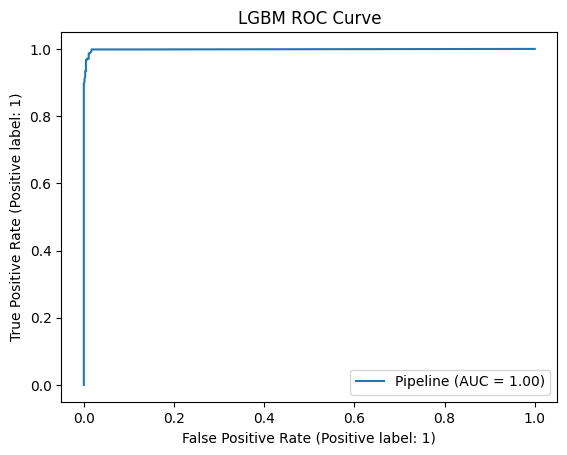

In [ ]:
pipe = Pipeline([("rf", RandomForestClassifier())])

y_pred = pipe.fit(X_train, y_train).predict(X_test)

RocCurveDisplay.from_estimator(pipe, X_test, y_test)
plt.title("LGBM ROC Curve")

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       647
           1       0.99      0.99      0.99       653

    accuracy                           0.99      1300
   macro avg       0.99      0.99      0.99      1300
weighted avg       0.99      0.99      0.99      1300



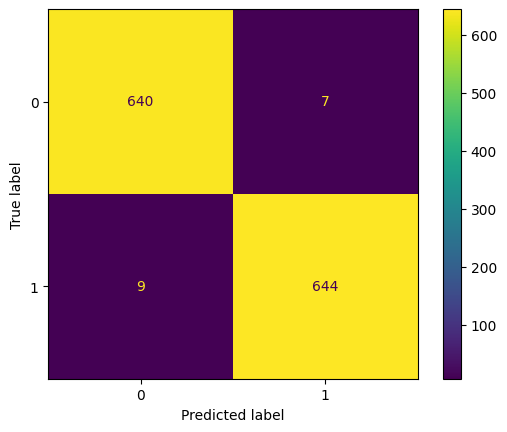

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
print(classification_report(y_test, y_pred))

In [ ]:
cv_result = cross_val_score(pipe, X_train, y_train, cv=kfold, scoring="accuracy")
print(cv_result.mean())

0.9805769230769229


In [ ]:
pipe.get_params()

{'memory': None,
 'steps': [('rf', RandomForestClassifier())],
 'verbose': False,
 'rf': RandomForestClassifier(),
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'sqrt',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 100,
 'rf__n_jobs': None,
 'rf__oob_score': False,
 'rf__random_state': None,
 'rf__verbose': 0,
 'rf__warm_start': False}

In [ ]:
rf_params = {
    "rf__max_depth" : [i for i in range(1, 11)],
    "rf__min_samples_leaf" : [1, 2, 3],
    "rf__n_estimators" : [i for i in range(100, 2100, 100)],
    "rf__max_leaf_nodes" : [i for i in range(1, 101)]
}

gs_rf = RandomizedSearchCV(pipe, rf_params, cv=kfold, scoring="accuracy").fit(X_train, y_train)

In [ ]:
gs_rf.best_params_

{'rf__n_estimators': 1900,
 'rf__min_samples_leaf': 2,
 'rf__max_leaf_nodes': 48,
 'rf__max_depth': 7}

Text(0.5, 1.0, 'RF Final ROC Curve')

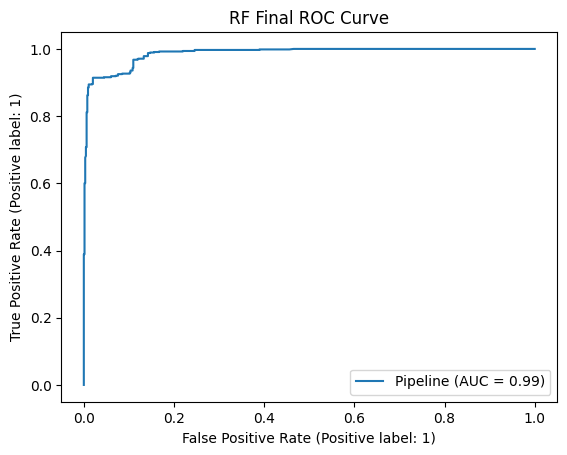

In [ ]:
rf_final = pipe.set_params(**gs_rf.best_params_).fit(X_train, y_train)

y_pred_final = rf_final.predict(X_test)

RocCurveDisplay.from_estimator(rf_final, X_test, y_test)
plt.title("RF Final ROC Curve")

              precision    recall  f1-score   support

           0       0.95      0.89      0.92       647
           1       0.90      0.96      0.93       653

    accuracy                           0.92      1300
   macro avg       0.93      0.92      0.92      1300
weighted avg       0.93      0.92      0.92      1300



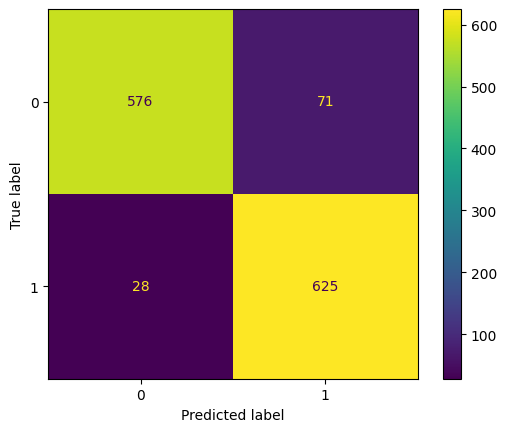

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_final)).plot()
print(classification_report(y_test, y_pred_final))

In [ ]:
cv_result = cross_val_score(rf_final, X_train, y_train, cv=kfold, scoring="accuracy")
print(cv_result.mean())

0.9311538461538461


In [ ]:
df[df['Stunting'] == 1].head()

,Sex,Age,Birth Weight,Birth Length,Body Weight,Body Length,ASI Eksklusif,Stunting
7,1,33,2.5,49,10.0,91.5,0,1
10,1,16,2.4,48,6.6,76.0,1,1
11,0,47,2.5,49,10.0,91.5,0,1
16,0,3,2.8,48,6.0,54.0,0,1
19,0,19,3.0,52,7.7,57.0,1,1


In [ ]:
# Testing

data = pd.DataFrame({
    "Sex":['F'],
    'Age':[24],
    'Birth Weight':[4.3],
    'Birth Length':[49],
    'Body Weight':[9.1],
    'Body Length':[87],
    'ASI Eksklusif':['Yes']
})

data['Sex'] = sex_encoder.transform(data['Sex'])
data['ASI Eksklusif'] = asi_encoder.transform(data['ASI Eksklusif'])

stunting_pred = rf_final.predict_proba(data)
stunting = rf_final.predict(data)[0]
if stunting_pred[0][1] >= 0.5:
    print(f"Stunting: Yes, dengan persentase Yes: {round(stunting_pred[0][1], 2)*100}%")
    print(f"Stunting: {stunting}")
else:
    print(f"Stunting: No, dengan persentase No: {round(stunting_pred[0][0], 2)*100}%")
    print(f"Stunting: {stunting}")

Stunting: No, dengan persentase No: 85.0%
Stunting: 0
